In [2]:
import cmdstanpy
import pandas as pd
import numpy as np
from cmdstanpy import cmdstan_path, CmdStanModel
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import json
import scipy.stats as stats
from sklearn.metrics import mean_squared_error

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

In [20]:
temps = pd.read_csv('data/Hyperlocal_Temperature_Monitoring.csv')
temps.head()

,Sensor.ID,AirTemp,Day,Hour,Latitude,Longitude,Year,Install.Type,Borough,ntacode
0,Bk-BR_01,71.189000,06/15/2018,1,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81
1,Bk-BR_01,70.243333,06/15/2018,2,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81
2,Bk-BR_01,69.392667,06/15/2018,3,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81
3,Bk-BR_01,68.263167,06/15/2018,4,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81
4,Bk-BR_01,67.114000,06/15/2018,5,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81


In [368]:
data = pd.read_csv('data/data.csv')

NameError: name 'pr' is not defined

In [364]:
covariates = pd.read_csv('data/temp3.csv').round(8)
covariates2 = pd.read_csv('data/temp_1.csv').round(8)
covariates = covariates.merge(covariates2)
covariates['mean_fa_ratio'] = covariates['mean_fa_ratio'].fillna(0)
temps = temps.drop(index=np.where(temps['AirTemp'].isna())[0]).reset_index(0)
temps = temps.groupby(['Latitude','Longitude','Day','Year']).agg({'AirTemp':np.max}).reset_index(0).reset_index(0).reset_index(0).reset_index(0)
data = temps.merge(covariates, how='outer', on=['Latitude','Longitude'])

In [369]:
data = pd.read_csv('data/data.csv')
data = data[pd.to_datetime(data.Day).dt.month.isin([7,8])].reset_index(0).drop(columns='index')
data['is_august'] = (pd.to_datetime(data.Day).dt.month == 8).astype(int)
data['bias'] = 1

In [375]:
g = data.groupby(['Sensor.ID','Day'])
X = []
y = []
for k,_ in tqdm(g.indices.items()):
    sub_group = g.get_group(k)
    y.append(np.max(sub_group['AirTemp']))
    X.append(sub_group[['num_build500','mean_fa_ratio','min_distance_park','num_trees_15m','is_august','bias']].iloc[0].values)
    
X = np.array(X)
y = np.array(y)

100%|█████████████████████████████████████████████| 43859/43859 [00:40<00:00, 1077.16it/s]


In [50]:
def a_w_i(k,i):
    arr = list(range(k))
    arr.remove(i)
    return arr

def create_splits(n,k):
    arr = np.arange(n)
    random.shuffle(arr)
    splits = np.array(np.array_split(arr,k),dtype=object)
    return [(np.concatenate(splits[a_w_i(k,i)]),splits[i]) for i in range(k)]

In [51]:
MODEL_PATH_CV = 'models/max_model_cv.stan'
MODEL_PATH = 'models/max_model.stan'

In [367]:
pd.read_csv('data/data.csv')

,Sensor.ID,AirTemp,Day,Hour,Latitude,Longitude,Year,Install.Type,Borough,ntacode,num_build500,mean_fa_ratio,min_distance_park,num_trees_15m
0,Bk-BR_01,71.189000,06/15/2018,1,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81,30,1.430347,67.776238,4
1,Bk-BR_01,70.243333,06/15/2018,2,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81,30,1.430347,67.776238,4
2,Bk-BR_01,69.392667,06/15/2018,3,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81,30,1.430347,67.776238,4
3,Bk-BR_01,68.263167,06/15/2018,4,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81,30,1.430347,67.776238,4
4,Bk-BR_01,67.114000,06/15/2018,5,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81,30,1.430347,67.776238,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085438,Q-CH_26,78.346667,09/07/2019,15,40.699578,-73.73876,2019,Light Pole,Queens,QN33,28,1.319975,124.765218,0
2085439,Q-CH_26,79.517167,09/07/2019,16,40.699578,-73.73876,2019,Light Pole,Queens,QN33,28,1.319975,124.765218,0
2085440,Q-CH_26,77.203667,09/07/2019,17,40.699578,-73.73876,2019,Light Pole,Queens,QN33,28,1.319975,124.765218,0
2085441,Q-CH_26,75.696000,09/07/2019,18,40.699578,-73.73876,2019,Light Pole,Queens,QN33,28,1.319975,124.765218,0


In [377]:
n = X.shape[0]
idx = list(range(n))
random.shuffle(idx)
train = int(0.8 * n)
X_train,y_train = X[:train,:],y[:train]
X_val,y_val = X[train:,:],y[train:]

In [378]:
d = {'M': X_train.shape[0],
     'K': X.shape[1],
     'T': X_val.shape[0],
     'L': 1000,
     'S': 100,
     'X': X_train, 
     'y': y_train,
     'X_val':X_val}
    
model = CmdStanModel(stan_file=MODEL_PATH)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/sotiriskaragounis/git/UHInyc/models/max_model


In [379]:
t1 = time()
mcmc = model.variational(data=d,output_dir='misc',save_diagnostics=True)
t2 = time()

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [380]:
y_sims = mcmc.stan_variable(var='y_rep')
y_out = mcmc.stan_variable(var='y_out')
b = mcmc.stan_variable(var='beta')

In [383]:
mean_squared_error(y_val,y_out)

856.2912164663466

In [ ]:
list(bern_vb.variational_params_dict.items())[:10]

NameError: name 'bern_vb' is not defined

In [279]:
def agg(simulated_data,y,agg_func):
    agg_data = agg_func(simulated_data,axis=1)
    return agg_data,agg_func(y)

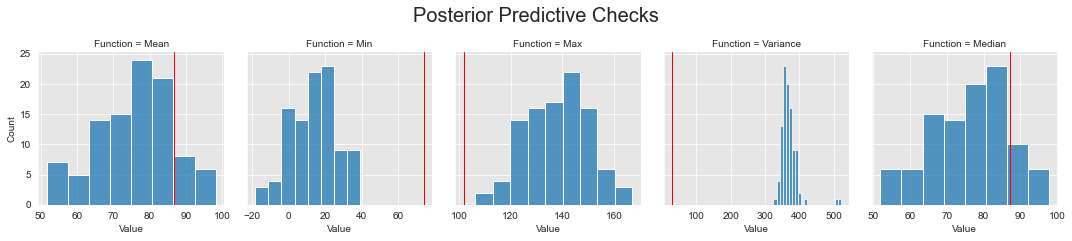

In [381]:
y_p = y_train[:200] 

functions = [np.mean,np.min,np.max,np.var,np.median]
titles = ['Mean','Min','Max','Variance','Median']
y_acc = []
df = pd.DataFrame()
for i,(func,title) in enumerate(zip(functions,titles)):
    agg_data,agg_y = agg(y_sims[:200,:],y_p,func)
    df_temp = pd.DataFrame({'Value':agg_data, 'Function': titles[i]})
    y_acc.append(agg_y)
    df = df.append(df_temp)
    
g = sns.FacetGrid(df, col="Function",  sharex=False)
g.map_dataframe(sns.histplot, x="Value")
g.fig.suptitle('Posterior Predictive Checks',fontsize=20,y=1.1)

for i,ax in enumerate(g.axes[0]):
    ax.axvline(x = y_acc[i], color='red', linewidth=1,label='Original Data')

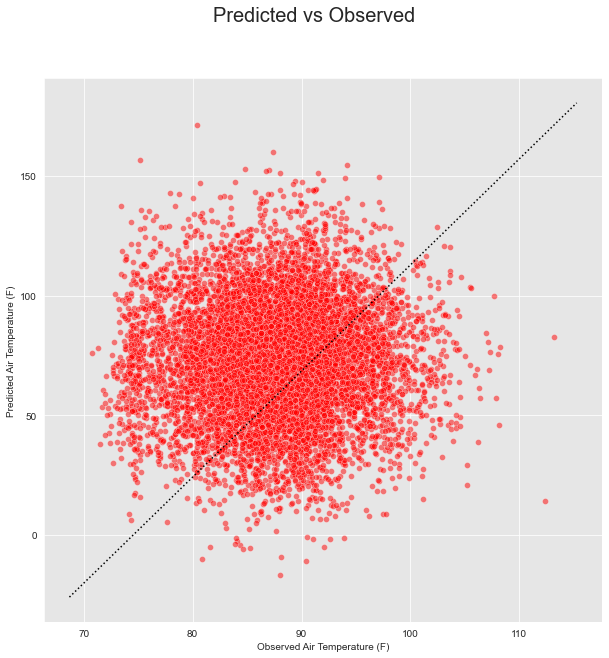

In [382]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(y=y_out,x=y_val,alpha=0.5,color='red')
ax.get_figure().suptitle('Predicted vs Observed',fontsize=20)
ax.set(xlabel='Observed Air Temperature (F)',ylabel='Predicted Air Temperature (F)')
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax.plot((x0,x1),(y0,y1), ':k')

In [328]:
data

,Year,Day,Longitude,Latitude,AirTemp,num_build500,mean_fa_ratio,min_distance_park,num_trees_15m,is_august,bias
0,2018,08/01/2018,-73.951234,40.646738,91.807333,31,1.179760,342.551291,3,1,1
1,2019,08/01/2019,-73.951234,40.646738,91.340833,31,1.179760,342.551291,3,1,1
2,2018,08/02/2018,-73.951234,40.646738,90.814333,31,1.179760,342.551291,3,1,1
3,2019,08/02/2019,-73.951234,40.646738,87.475000,31,1.179760,342.551291,3,1,1
4,2018,08/03/2018,-73.951234,40.646738,87.613000,31,1.179760,342.551291,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...
21948,2018,08/27/2018,-73.849168,40.884616,97.372333,10,0.730596,362.881313,2,1,1
21949,2018,08/28/2018,-73.849168,40.884616,104.644333,10,0.730596,362.881313,2,1,1
21950,2018,08/29/2018,-73.849168,40.884616,103.932333,10,0.730596,362.881313,2,1,1
21951,2018,08/30/2018,-73.849168,40.884616,96.232833,10,0.730596,362.881313,2,1,1


In [350]:
vb_stats = pd.read_csv('misc/max_model-202112060254-1.csv')

ParserError: Error tokenizing data. C error: Expected 1 fields in line 35, saw 104401


In [362]:
class MaxModelPlots:

	def __init__(self,X_train,X_val,y_train,y_val,vb):
		self.cols = ['num_build500','mean_fa_ratio','min_distance_park','num_trees_15m','bias']
		self.y_sims = vb.stan_variable(var='y_rep')
		self.y_out = vb.stan_variable(var='y_out')
		self.b = vb.stan_variable(var='beta')

	def get_params(self):
		out_cols = ['beta[1]', 'beta[2]', 'beta[3]','beta[4]', 'beta[5]', 'sigma']
		dict_rename = dict(zip(out_cols,cols))
		return vb.variational_params_pd[out_cols].rename(columns=dict_rename)

	def mse(self):
		return mean_squared_error(self.y_val,self.y_out)

	def agg(self,simulated_data,y,agg_func):
	    agg_data = agg_func(simulated_data,axis=1)
	    return agg_data,agg_func(y)

	def posterior_predictive_checks(self):
		y_p = self.y_train[:self.L] 

		functions = [np.mean,np.min,np.max,np.var,np.median]
		titles = ['Mean','Min','Max','Variance','Median']
		y_acc = []

		df = pd.DataFrame()

		for i,(func,title) in enumerate(zip(functions,titles)):
			agg_data,agg_y = agg(self.y_sims,y_p,func)
			df_temp = pd.DataFrame({'Value':agg_data, 'Function': titles[i]})
			y_acc.append(agg_y)
			df = df.append(df_temp)
		
		g = sns.FacetGrid(df, col="Function",  sharex=False)
		g.map_dataframe(sns.histplot, x="Value")
		g.fig.suptitle('Posterior Predictive Checks',fontsize=20,y=1.1)

		for i,ax in enumerate(g.axes[0]):
			ax.axvline(x = y_acc[i], color='red', linewidth=1,label='Original Data')

		plt.show()

	def predicted_v_observed(self):
		plt.figure(figsize=(10,10))
		ax = sns.scatterplot(y=self.y_out,x=self.y_val,alpha=0.5,color='red')
		ax.get_figure().suptitle('Predicted vs Observed',fontsize=20)
		ax.set(xlabel='Observed Air Temperature (F)',ylabel='Predicted Air Temperature (F)')
		x0, x1 = ax.get_xlim()
		y0, y1 = ax.get_ylim()
		lims = [max(x0, y0), min(x1, y1)]
		ax.plot((x0,x1),(y0,y1), ':k')
		plt.show()
